# Example 6: Rocking curves

With `m2SANS` you can simulate scattering patterns for rocking curves, where either the sample or the sample environment is rotated or tilted in the neutron beam. This will affect the magnetic scattering in a variety of ways:

- First, the spatial arrangement (repectively projection) of scatterers is modified.
- Second, the magnetisation components $\vec{M}_{\perp}(\vec{Q})$ perpendicular to the scattering vector $\vec{Q}$ change, which affects the magnetic scattering lengths $\vec{b}_{\vec{M}_{\perp}}$
- Third, the neutron polarisation $\vec{P}$ is modified if the sample environment is rotated. This will affect the projections of the magnetic scattering lenght, and ultimatively the distribution of the scattering cross sections.

## How to simulate a rocking curve

To simulate a rocking curve, for each rotation setting you have to initialise a new `mm2SANS.Experiment` object -- which contains the transformed coordinates $\vec{R}_i$ and moments $\vec{M}_i$ of the individual scatterers and the neutron polarisation $\vec{P}$, all defined in the beamline coordinate system ($U$, $V$, $W$) -- and then calculate the scattering patterns.

To do so, follow these steps (some may be omitted, but please carefult to not overwrite settings inadvertedly):

1. Initialise your `mm2SANS.Sample` and `mm2SANS.Probe` object. This only needs to be done in the beginning. The following steps are then for each roation angle.
2. Re-set the neutron polarisation.
3. Set sample rotations and sample environment roations.
4. Calculate the rotation matrices.
5. Initiate a new `mm2SANS.Experiment` object, which takes care of all transformations.
6. Optional: If the neutron polarisation $\vec{P}$ is _not_ set within the sample environment but within beamline coordinate system, you have to re-set the value of `mm2SANS.Experiment.Probe.Beamline.neutron_polarisation` accordingly.
7. Calculate the scattering patterns.
8. Visualise.

### Initialise Sample and Probe object

In the follwing, we consider a uniformly magnetised sphere along (0, 1, 0), i.e. parallel to the horizontal detector plane, and a longitudinal neutron polarisation (1, 0, 0), i.e. parallel to the beam. The sample is subjected to “yaw” rotations, which correspond to rotations around the vertical detector axis. 

In [1]:
import mm2SANS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# general settings
moment_direction = [0, 1, 0]
neutron_polarisation = [1, 0, 0]

# settings for rocking curve
rotation_axis, num_rotations, delta_phi, plot_property = 'yaw', 4, 2.5, 'I_dif'

# get list of rotation angles
rotation_list = np.arange(0, (num_rotations+1) * delta_phi, delta_phi) - num_rotations / 2 * delta_phi

In [3]:
""" create the Sample object (using settings from Example 1)"""
sample = mm2SANS.Sample(
    positions=[[0, 0, 0]],
    moments=[moment_direction],
    scattering_length_density=(8.024-0.001j),
    saturation_magnetisation=800e3,
    voxel_volumes= 4/3 * np.pi * 10e-9**3 ,
    periodicity=(50e-9, 50e-9, 50e-9),
    print_diagnostics=False,
    )

""" create a Detector object (using Settings from Example 2) """
probe = mm2SANS.Probe(
      sans_instrument='test'
    , neutron_wavelength=6e-10 # in m
    , detector_distance=15 # in m
    , qmap_disorder=0.35 # to avoid Fourier transform artefacts
    , neutron_polarisation=neutron_polarisation
   )

### Rocking curves: Plot scattering patterns

In this case, showing a reversal of the magnetic contrast...

C:\ProgramData\Anaconda3\lib\site-packages\mm2sans-0.1-py3.6.egg\mm2SANS\experiment.py:650: UserWarning: No contour levels were found within the data range.


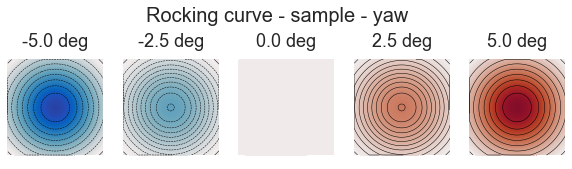

In [4]:
# initialise figure
axis_size = 2
fig = plt.figure( figsize = (axis_size * (num_rotations+1), axis_size) )
fig.suptitle(f'Rocking curve - sample - {rotation_axis}', fontsize=20, y=1.2)
gs = gridspec.GridSpec(1, (num_rotations+1) )

#data limit, so that all curves are scaled the same
col_limit = 1.5

# iterate over rotation angles
for i, phi in enumerate(rotation_list):

    # re-set neutron polarisation (not really neccessary here)
    probe.Beamline.neutron_polarisation = neutron_polarisation
    # set rotations (setting the environment rotations is not really neccessary here)
    probe.Beamline.sample_rotations = [[rotation_axis, phi]]
    probe.Beamline.sample_environment_rotations = []
    # re-calculate rotation matices
    probe.Beamline.calc_rotation_matrices()

    # create experiment and calculate scattering patterns
    experiment = mm2SANS.Experiment(sample, probe, print_diagnostics=False)
    experiment.calc_scattering_pattern(uc_repetitions=(1,1,1))

    # plot up the chosen data column
    ax = plt.subplot(gs[0, i])
    experiment.plot_property( plot_property, ax=ax
                             , title=f'{phi} deg'
                             , limit=col_limit )
    ax.axis('off')

### ... one more example...

Here, a single sphere uniformly magnetised along (0, 0, 1), i.e. the vertical detector direction and a transverse neutron polarisation along (0, 1, 0), i.e. horizontal detector direction. The difference scattering patterns are obtained for “pitch” rotations which tilt the sample towards the detector.

In [5]:
# general settings
moment_direction = [0, 0, 1]
neutron_polarisation = [0, 1, 0]

# settings for rocking curve, and get list of rotation angles
rotation_axis, num_rotations, delta_phi, plot_property = 'pitch', 4, 5, 'I_dif'
rotation_list = np.arange(0, (num_rotations+1) * delta_phi, delta_phi) - num_rotations / 2 * delta_phi

In [6]:
""" create the Sample object (using settings from Example 1)"""
sample = mm2SANS.Sample(
    positions=[[0, 0, 0]],
    moments=[moment_direction],
    scattering_length_density=(8.024-0.001j),
    saturation_magnetisation=800e3,
    voxel_volumes= 4/3 * np.pi * 10e-9**3 ,
    periodicity=(50e-9, 50e-9, 50e-9),
    print_diagnostics=False,
    )

""" create a Detector object (using Settings from Example 2) """
probe = mm2SANS.Probe(
      sans_instrument='test'
    , neutron_wavelength=6e-10 # in m
    , detector_distance=15 # in m
    , qmap_disorder=0.35 # to avoid Fourier transform artefacts
    , neutron_polarisation=neutron_polarisation
   )

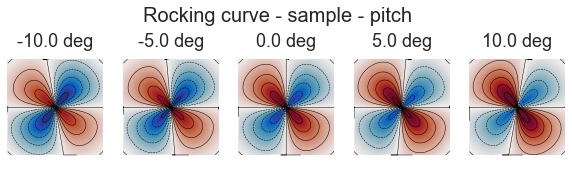

In [7]:
# initialise figure
axis_size = 2
fig = plt.figure( figsize = (axis_size * (num_rotations+1), axis_size) )
fig.suptitle(f'Rocking curve - sample - {rotation_axis}', fontsize=20, y=1.2)
gs = gridspec.GridSpec(1, (num_rotations+1) )

#data limit, so that all curves are scaled the same
col_limit = 7.5

# iterate over rotation angles
for i, phi in enumerate(rotation_list):

    # re-set neutron polarisation (not really neccessary here)
    probe.Beamline.neutron_polarisation = neutron_polarisation
    # set rotations (setting the environment rotations is not really neccessary here)
    probe.Beamline.sample_rotations = [[rotation_axis, phi]]
    probe.Beamline.sample_environment_rotations = []
    # re-calculate rotation matices
    probe.Beamline.calc_rotation_matrices()

    # create experiment and calculate scattering patterns
    experiment = mm2SANS.Experiment(sample, probe, print_diagnostics=False)
    experiment.calc_scattering_pattern(uc_repetitions=(1,1,1))

    # plot up the chosen data column
    ax = plt.subplot(gs[0, i])
    experiment.plot_property( plot_property, ax=ax
                             , title=f'{phi} deg'
                             , limit=col_limit )
    ax.axis('off')